# 生成对抗网络(GAN)卡通图像生成
[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)]()&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)]()&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)]()
&#160;&#160;&#160;&#160;&#160;&#160;&#160;
本实验使用GAN网络实现卡通图像生成任务，使用的数据集来自CSDN。结合课程学习，通过本实验可以了解GAN的结构和数据处理相关知识，并且掌握如何训练和提升模型效果及微调训练等操作技巧。
## 实验介绍
&#160;&#160;&#160;&#160;&#160;&#160;&#160;
深度学习不仅在于其强大的学习能力，更在于它的创新能力。我们通过构建判别模型来提升模型的学习能力，通过构建生成模型来发挥其创新能力。判别模型通常利用训练样本训练模型,然后利用该模型，对新样本x，进行判别或预测。而生成模型正好反过来，根据一些规则y，来生成新样本x。生成式模型很多，变分自动编码器(VAE)和生成式对抗网络(GAN)及其变种。虽然两者都是生成模型，并且通过各自的生成能力展现其强大的创新能力，但他们在具体实现上有所不同，其中生成对抗网络生成效果较好。
<br/>&#160;&#160;&#160;&#160;&#160;&#160;&#160;
生成对抗网络(GAN,Generative Aderversarial Networks)作为一种深度学习框架，是近几年来无监督学习方法最具前景的方法之一。2014年，lan Goodfellow发表论文《Generative Adversarial Net》首次对GAN进行了说明描述。如图所示，GAN由两个模型组成：(1)生成模型（生成器）；(2)判别模型（判别器）。在实验过程中，生成器会生成像训练图像的“高仿图像”，而判别器则需要判断生成器中的图像是否为真实图像。为了这个目的，生成器在每轮训练中会提高造假质量以生成更好的“假图像”来骗过判别器。判别器也需要提升判别能力来分辨是否造假。这形成了一种博弈，博弈的平衡点就是生成器生成的图像非常真实，二判别器判别概率为50%。
![total]("./img/total.png")
<br/>&#160;&#160;&#160;&#160;&#160;&#160;&#160;

## 数据集加载

### 数据集准备

&#160;&#160;&#160;&#160;&#160;&#160;&#160;在本次实验中，将使用动漫头像数据集，该数据集包含21551张各式各样的卡通动漫头像，如图1所示。每张图像大小为64×64。为了使程序运行流畅，本次实验在当前路径下创建一个data目录，并在此目录下创建一个名为train的子目录。
![picface]("./img/picface.png")

&#160;&#160;&#160;&#160;&#160;&#160;&#160;
数据集的目录结构为：
<br/>&#160;&#160;&#160;&#160;&#160;&#160;&#160; 
.\data
<br/>&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;
└─train
<br/>&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;
......
<br/>&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;
10001.png
<br/>&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;
10002.png
<br/>&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;
10003.png
<br/>&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;
10004.png
<br/>&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;
......
### 数据集加载

&#160;&#160;&#160;&#160;&#160;&#160;&#160;
本次实验案例需在CPU和华为云NPU进行运行，所以应根据要求分别运行后续代码（只运行一个代码块）。

#### 使用CPU进行数据集加载

&#160;&#160;&#160;&#160;&#160;&#160;&#160;
使用GRAPH的模式运行实验，并对相关参数进行定义。

In [11]:
from mindspore import set_context, GRAPH_MODE

# 选择执行模式为图模式；指定训练使用的平台为"GPU"，如需使用昇腾硬件可将其替换为"Ascend"
set_context(mode=GRAPH_MODE, device_target="CPU")

data_root = "./data"  # 数据集根目录
workers = 4  # 载入数据线程数
batch_size = 128  # 批量大小
image_size = 64  # 训练图像空间大小，所有图像都将调整为该大小
nc = 3  # 图像彩色通道数，对于彩色图像为3
nz = 100  # 隐向量的长度
ngf = 64  # 特征图在生成器中的大小
ndf = 64  # 特征图在判别器中的大小
num_epochs = 10  # 训练周期数
lr = 0.0002  # 学习率
beta1 = 0.5  # Adam优化器的beta1超参数

#### 使用NPU进行数据集加载

&#160;&#160;&#160;&#160;&#160;&#160;&#160;
调用argparse模块进行NPU上的加载，代码如下：

In [ ]:
import moxing
import argparse
# 定义目录
parser = argparse.ArgumentParser()
parser.add_argument('--data_url', required=False, default='minist/', help='Location of data.')
parser.add_argument('--train_url', required=False, default=None, help='Location of training outputs.')
args, unknown = parser.parse_known_args()

if args.data_url.startswith('s3'):

    moxing.file.copy_parallel(src_url=args.data_url, dst_url='minist/')

    data_path = 'minist/'
else:
    data_path = os.path.abspath(args.data_url)

#### 数据预处理和可视化

&#160;&#160;&#160;&#160;&#160;&#160;&#160;
自定义函数create_dataset_imagenet对数据进行处理和增强

In [12]:
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as vision

def create_dataset_imagenet(dataset_path, num_parallel_workers=None):
    """数据加载"""
    data_set = ds.ImageFolderDataset(dataset_path, num_parallel_workers=num_parallel_workers, shuffle=True,
                                     decode=True)

    # 数据增强操作
    transform_img = [
        vision.Resize(image_size),
        vision.CenterCrop(image_size),
        vision.HWC2CHW(),
        lambda x: ((x / 255).astype("float32"), np.random.normal(size=(nz, 1, 1)).astype("float32"))
    ]

    # 数据映射操作
    data_set = data_set.map(input_columns="image", num_parallel_workers=num_parallel_workers, operations=transform_img,
                            output_columns=["image", "latent_code"], column_order=["image", "latent_code"])

    # 批量操作
    data_set = data_set.batch(batch_size)
    return data_set

# 获取处理后的数据集
data = create_dataset_imagenet(data_root, num_parallel_workers=workers)

# 获取数据集大小
size = data.get_dataset_size()
print(size)

169


&#160;&#160;&#160;&#160;&#160;&#160;&#160;
对数据集图像进行可视化操作

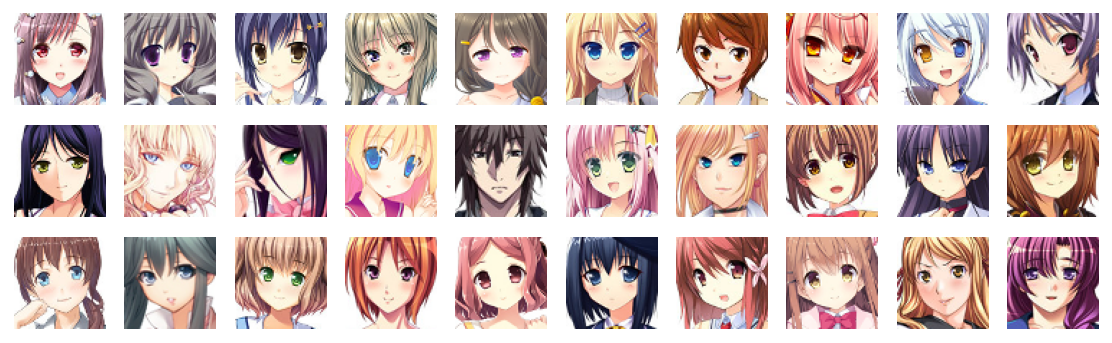

In [13]:
import matplotlib.pyplot as plt

data_iter = next(data.create_dict_iterator(output_numpy=True))

# 可视化部分训练数据
plt.figure(figsize=(10, 3), dpi=140)
for i, image in enumerate(data_iter['image'][:30], 1):
    plt.subplot(3, 10, i)
    plt.axis("off")
    plt.imshow(image.transpose(1, 2, 0))
plt.show()

## 判别器与生成器模型建立

&#160;&#160;&#160;&#160;&#160;&#160;&#160;
处理数据后，需搭建GAN的网络模型，本节分别从权重初始化出发，搭建生成器、判别器和损失函数模型。

### 生成器模型
&#160;&#160;&#160;&#160;&#160;&#160;&#160;
生成器G通过图像反卷积操作将噪声图像生成目标图像，最后通过判别器来评估其接近真实图像的程度，生成器结构如图所示
![G]("./img/G.png")
&#160;&#160;&#160;&#160;&#160;&#160;&#160;
生成器模型建立的代码如下

In [14]:
from mindspore import nn
from mindspore.common.initializer import Normal

def conv_t(in_channels, out_channels, kernel_size, stride=1, padding=0, pad_mode="pad"):
    """定义转置卷积层"""
    weight_init = Normal(mean=0, sigma=0.02)
    return nn.Conv2dTranspose(in_channels, out_channels,
                              kernel_size=kernel_size, stride=stride, padding=padding,
                              weight_init=weight_init, has_bias=False, pad_mode=pad_mode)

def bn(num_features):
    """定义BatchNorm2d层"""
    gamma_init = Normal(mean=1, sigma=0.02)
    return nn.BatchNorm2d(num_features=num_features, gamma_init=gamma_init)

class Generator(nn.Cell):
    """DCGAN网络生成器"""

    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.SequentialCell()
        self.generator.append(conv_t(nz, ngf * 8, 4, 1, 0))
        self.generator.append(bn(ngf * 8))
        self.generator.append(nn.ReLU())
        self.generator.append(conv_t(ngf * 8, ngf * 4, 4, 2, 1))
        self.generator.append(bn(ngf * 4))
        self.generator.append(nn.ReLU())
        self.generator.append(conv_t(ngf * 4, ngf * 2, 4, 2, 1))
        self.generator.append(bn(ngf * 2))
        self.generator.append(nn.ReLU())
        self.generator.append(conv_t(ngf * 2, ngf, 4, 2, 1))
        self.generator.append(bn(ngf))
        self.generator.append(nn.ReLU())
        self.generator.append(conv_t(ngf, nc, 4, 2, 1))
        self.generator.append(nn.Tanh())

    def construct(self, x):
        return self.generator(x)

# 实例化生成器
netG = Generator()
print(netG)

Generator<
  (generator): SequentialCell<
    (0): Conv2dTranspose<input_channels=100, output_channels=512, kernel_size=(4, 4), stride=(1, 1), pad_mode=pad, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.Normal object at 0x000001D9976AE588>, bias_init=zeros>
    (1): BatchNorm2d<num_features=512, eps=1e-05, momentum=0.09999999999999998, gamma=Parameter (name=1.gamma, shape=(512,), dtype=Float32, requires_grad=True), beta=Parameter (name=1.beta, shape=(512,), dtype=Float32, requires_grad=True), moving_mean=Parameter (name=1.moving_mean, shape=(512,), dtype=Float32, requires_grad=False), moving_variance=Parameter (name=1.moving_variance, shape=(512,), dtype=Float32, requires_grad=False)>
    (2): ReLU<>
    (3): Conv2dTranspose<input_channels=512, output_channels=256, kernel_size=(4, 4), stride=(2, 2), pad_mode=pad, padding=1, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.Normal object at 0x000001D99768

### 判别器模型
&#160;&#160;&#160;&#160;&#160;&#160;&#160;
判别器对生成器生成的图像进行判别，最终输出一个概率值来判断是否为真实图像。其结构如图所示
![D]("./img/D.png")
&#160;&#160;&#160;&#160;&#160;&#160;&#160;
判别器模型建立的代码如下

In [15]:
from mindspore import nn
from mindspore.common.initializer import Normal

def conv(in_channels, out_channels, kernel_size, stride=1, padding=0, pad_mode="pad"):
    """定义卷积层"""
    weight_init = Normal(mean=0, sigma=0.02)
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight_init, has_bias=False, pad_mode=pad_mode)

class Discriminator(nn.Cell):
    """DCGAN网络判别器"""

    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.SequentialCell()
        self.discriminator.append(conv(nc, ndf, 4, 2, 1))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf, ndf * 2, 4, 2, 1))
        self.discriminator.append(bn(ndf * 2))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf * 2, ndf * 4, 4, 2, 1))
        self.discriminator.append(bn(ndf * 4))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf * 4, ndf * 8, 4, 2, 1))
        self.discriminator.append(bn(ndf * 8))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf * 8, 1, 4, 1))
        self.discriminator.append(nn.Sigmoid())

    def construct(self, x):
        return self.discriminator(x)

# 实例化判别器
netD = Discriminator()
print(netD)

Discriminator<
  (discriminator): SequentialCell<
    (0): Conv2d<input_channels=3, output_channels=64, kernel_size=(4, 4), stride=(2, 2), pad_mode=pad, padding=1, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.Normal object at 0x000001D995A59908>, bias_init=zeros, format=NCHW>
    (1): LeakyReLU<>
    (2): Conv2d<input_channels=64, output_channels=128, kernel_size=(4, 4), stride=(2, 2), pad_mode=pad, padding=1, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.Normal object at 0x000001D997AB1FC8>, bias_init=zeros, format=NCHW>
    (3): BatchNorm2d<num_features=128, eps=1e-05, momentum=0.09999999999999998, gamma=Parameter (name=3.gamma, shape=(128,), dtype=Float32, requires_grad=True), beta=Parameter (name=3.beta, shape=(128,), dtype=Float32, requires_grad=True), moving_mean=Parameter (name=3.moving_mean, shape=(128,), dtype=Float32, requires_grad=False), moving_variance=Parameter (name=3.moving_variance, shape=(128

### 损失函数与优化器创建

&#160;&#160;&#160;&#160;&#160;&#160;&#160;
Mindspore将损失函数和优化器都封装到了Cell中，由于GAN结构比较特殊，导致它和一般的分类网络不同，因此我们需要自定义WithLossCell类，起到连接网络和Loss的作用。代码如下

In [16]:
class WithLossCellG(nn.Cell):
    """连接生成器和损失"""

    def __init__(self, netD, netG, loss_fn):
        super(WithLossCellG, self).__init__(auto_prefix=True)
        self.netD = netD
        self.netG = netG
        self.loss_fn = loss_fn

    def construct(self, latent_code):
        """构建生成器损失计算结构"""
        fake_data = self.netG(latent_code)
        out = self.netD(fake_data)
        label_real = ops.OnesLike()(out)
        loss = self.loss_fn(out, label_real)
        return loss
    
class WithLossCellD(nn.Cell):
    """连接判别器和损失"""

    def __init__(self, netD, netG, loss_fn):
        super(WithLossCellD, self).__init__(auto_prefix=True)
        self.netD = netD
        self.netG = netG
        self.loss_fn = loss_fn

    def construct(self, real_data, latent_code):
        """构建判别器损失计算结构"""
        out_real = self.netD(real_data)
        label_real = ops.OnesLike()(out_real)
        loss_real = self.loss_fn(out_real, label_real)

        fake_data = self.netG(latent_code)
        fake_data = ops.stop_gradient(fake_data)
        out_fake = self.netD(fake_data)
        label_fake = ops.ZerosLike()(out_fake)
        loss_fake = self.loss_fn(out_fake, label_fake)
        return loss_real + loss_fake

&#160;&#160;&#160;&#160;&#160;&#160;&#160;
创建了生成器和判别器模型后，接下来使用Mindspore定义损失函数和优化器。

In [19]:
from mindspore import Tensor
from mindspore import dtype as mstype

# 定义损失函数
criterion = nn.BCELoss(reduction='mean')

# 创建一批隐向量用来观察G
np.random.seed(1)
fixed_noise = Tensor(np.random.randn(64, nz, 1, 1), dtype=mstype.float32)

# 为生成器和判别器设置优化器
optimizerD = nn.Adam(netD.trainable_params(), learning_rate=lr, beta1=beta1)
optimizerG = nn.Adam(netG.trainable_params(), learning_rate=lr, beta1=beta1)

## GAN模型训练

### 定义网络
&#160;&#160;&#160;&#160;&#160;&#160;&#160;
通过建立DCGAN(nn.Ceil)类，为网络实例化做基础。

In [21]:
class DCGAN(nn.Cell):
    """定义DCGAN网络"""

    def __init__(self, myTrainOneStepCellForD, myTrainOneStepCellForG):
        super(DCGAN, self).__init__(auto_prefix=True)
        self.myTrainOneStepCellForD = myTrainOneStepCellForD
        self.myTrainOneStepCellForG = myTrainOneStepCellForG

    def construct(self, real_data, latent_code):
        output_D = self.myTrainOneStepCellForD(real_data, latent_code).view(-1)
        netD_loss = output_D.mean()
        output_G = self.myTrainOneStepCellForG(latent_code).view(-1)
        netG_loss = output_G.mean()
        return netD_loss, netG_loss
    
# 实例化WithLossCell
netD_with_criterion = WithLossCellD(netD, netG, criterion)
netG_with_criterion = WithLossCellG(netD, netG, criterion)

# 实例化TrainOneStepCell
myTrainOneStepCellForD = nn.TrainOneStepCell(netD_with_criterion, optimizerD)
myTrainOneStepCellForG = nn.TrainOneStepCell(netG_with_criterion, optimizerG)

&#160;&#160;&#160;&#160;&#160;&#160;&#160;
实例化GAN网络，并对网络进行循环训练。

In [24]:
from mindspore import ops
from mindspore import save_checkpoint

# 实例化DCGAN网络
dcgan = DCGAN(myTrainOneStepCellForD, myTrainOneStepCellForG)
dcgan.set_train()

# 创建迭代器
data_loader = data.create_dict_iterator(output_numpy=True, num_epochs=num_epochs)
G_losses = []
D_losses = []
image_list = []

# 开始循环训练
print("Starting Training Loop...")

for epoch in range(num_epochs):
    # 为每轮训练读入数据
    for i, d in enumerate(data_loader):
        real_data = Tensor(d['image'])
        latent_code = Tensor(d["latent_code"])
        netD_loss, netG_loss = dcgan(real_data, latent_code)
        if i % 50 == 0 or i == size - 1:
            # 输出训练记录
            print('[%2d/%d][%3d/%d]   Loss_D:%7.4f  Loss_G:%7.4f' % (
                epoch + 1, num_epochs, i + 1, size, netD_loss.asnumpy(), netG_loss.asnumpy()))
        D_losses.append(netD_loss.asnumpy())
        G_losses.append(netG_loss.asnumpy())

    # 每个epoch结束后，使用生成器生成一组图片
    img = netG(fixed_noise)
    image_list.append(img.transpose(0, 2, 3, 1).asnumpy())

    # 保存网络模型参数为ckpt文件
    save_checkpoint(netG, "Generator.ckpt")
    save_checkpoint(netD, "Discriminator.ckpt")

Starting Training Loop...
[ 1/10][  1/169]   Loss_D: 0.6292  Loss_G: 5.4720
[ 1/10][ 51/169]   Loss_D: 0.2405  Loss_G: 3.9342
[ 1/10][101/169]   Loss_D: 0.5272  Loss_G: 4.3058
[ 1/10][151/169]   Loss_D: 1.1382  Loss_G: 8.4566
[ 1/10][169/169]   Loss_D: 0.7215  Loss_G: 6.5256
[ 2/10][  1/169]   Loss_D: 0.6046  Loss_G: 3.9933
[ 2/10][ 51/169]   Loss_D: 0.5435  Loss_G: 5.5654
[ 2/10][101/169]   Loss_D: 1.0772  Loss_G: 8.9450
[ 2/10][151/169]   Loss_D: 0.6406  Loss_G: 5.1029
[ 2/10][169/169]   Loss_D: 0.6424  Loss_G: 4.0972
[ 3/10][  1/169]   Loss_D: 0.7011  Loss_G: 6.4152
[ 3/10][ 51/169]   Loss_D: 1.1257  Loss_G: 9.0922
[ 3/10][101/169]   Loss_D: 0.5876  Loss_G: 8.8948
[ 3/10][151/169]   Loss_D: 0.6492  Loss_G: 5.1705
[ 3/10][169/169]   Loss_D: 0.3617  Loss_G: 2.9810
[ 4/10][  1/169]   Loss_D: 1.7265  Loss_G:12.2027
[ 4/10][ 51/169]   Loss_D: 1.1629  Loss_G: 8.8626
[ 4/10][101/169]   Loss_D: 0.4614  Loss_G: 5.2844
[ 4/10][151/169]   Loss_D: 0.7615  Loss_G: 6.9187
[ 4/10][169/169]   Loss_

### 可视化结果验证

&#160;&#160;&#160;&#160;&#160;&#160;&#160;
运行下面代码，描述生成器和判别器的损失训练迭代关系图

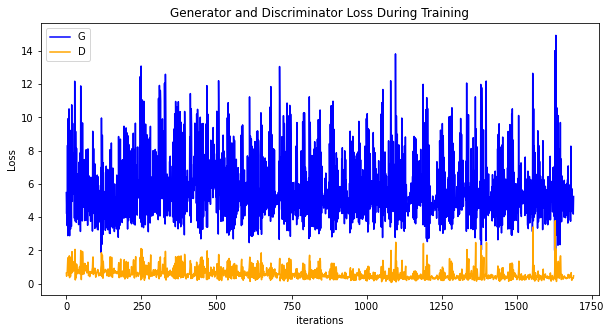

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G", color='blue')
plt.plot(D_losses, label="D", color='orange')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

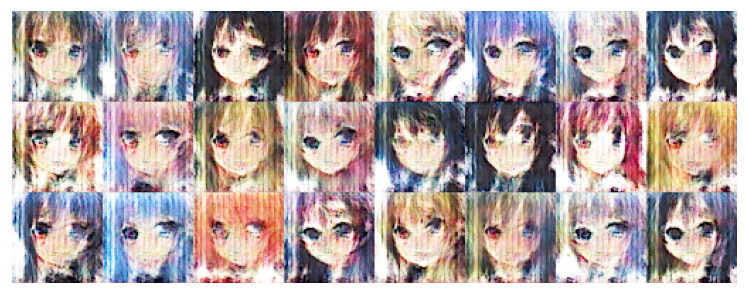

In [27]:
import matplotlib.animation as animation

def showGif(image_list):
    show_list = []
    fig = plt.figure(figsize=(8, 3), dpi=120)
    for epoch in range(len(image_list)):
        images = []
        for i in range(3):
            row = np.concatenate((image_list[epoch][i * 8:(i + 1) * 8]), axis=1)
            images.append(row)
        img = np.clip(np.concatenate((images[:]), axis=0), 0, 1)
        plt.axis("off")
        show_list.append([plt.imshow(img)])

    ani = animation.ArtistAnimation(fig, show_list, interval=1000, repeat_delay=1000, blit=True)
    ani.save('./dcgan.gif', writer='pillow', fps=1)

showGif(image_list)

&#160;&#160;&#160;&#160;&#160;&#160;&#160;
生成卡通头像

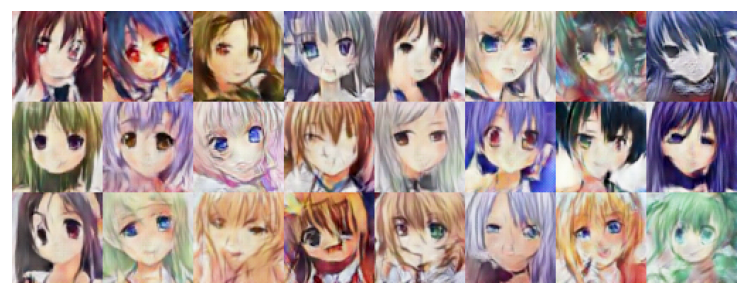

In [26]:
from mindspore import load_checkpoint
from mindvision import dataset

dl_path = "./netG"
dl_url = "https://download.mindspore.cn/vision/classification/Generator.ckpt"

dl = dataset.DownLoad()  # 下载Generator.ckpt文件
dl.download_url(url=dl_url, path=dl_path)

# 从文件中获取模型参数并加载到网络中
param_dict = load_checkpoint("./netG/Generator.ckpt", netG)

img64 = netG(fixed_noise).transpose(0, 2, 3, 1).asnumpy()

fig = plt.figure(figsize=(8, 3), dpi=120)
images = []
for i in range(3):
    images.append(np.concatenate((img64[i * 8:(i + 1) * 8]), axis=1))
img = np.clip(np.concatenate((images[:]), axis=0), 0, 1)
plt.axis("off")
plt.imshow(img)
plt.show()

## 实验小结

&#160;&#160;&#160;&#160;&#160;&#160;&#160;
本次实验构建了生成对抗网络模型，进行了动漫人物头像生成。